In [1]:
from dapnn.imports import *
from dapnn.data_processing import *
from fastai.tabular.model import get_emb_sz # get embedding size
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='once')

c:\Users\Rom\anaconda3\envs\dapnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
log_name='pdc_2020_0101100'
log = import_log(f'data/csv/PDC2020_training/{log_name}.csv.gz')
log.head(5)

,activity,trace_id,event_id
trace_id,,,
trace 1,###start###,trace 1,0
trace 1,t31,trace 1,1
trace 1,t41,trace 1,2
trace 1,t26,trace 1,3
trace 1,t36,trace 1,4


In [ ]:
# TODO: MAKE THIS THE FORMAT I WANT!

In [4]:
def training_dl(log,cat_names='activity',seed=45,ws=5,bs=32):
    categorify=Categorify()
    o=PPObj(log,procs=categorify,cat_names=cat_names,y_names=cat_names,splits=split_traces(log,test_seed=seed,validation_seed=seed))
    dls=o.get_dls(windows=partial(windows_fast,ws=ws),bs=bs)
    return o,dls,categorify

In [5]:
class ControlFlowModel(torch.nn.Module) :
    def __init__(self, o) :
        super().__init__()
        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        emb_dim_act = int(np.sqrt(vocab_act))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)
        
        self.lstm_act = nn.LSTM(emb_dim_act, hidden, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden, vocab_act)

    def forward(self, xcat):
        xcat=xcat[:,0]
        x_act=xcat
        x_act = self.emb_act(x_act)
        x_act,_ = self.lstm_act(x_act)
        x_act = x_act[:,-1]
        x_act = self.linear_act(x_act)
        return x_act

In [7]:
class HideOutput:
    'A utility function that hides all outputs in a context'
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def training_loop(learn,epoch,print_output,lr_find,fixed_learning_rate=0.01):
    '''
    Basic training loop that uses learning rate finder and one cycle training. 
    See fastai docs for more information
    '''
    if lr_find:
        lr=np.median([learn.lr_find(show_plot=print_output)[0] for i in range(5)])
        learn.fit_one_cycle(epoch,float(lr))
    else: learn.fit(epoch,fixed_learning_rate)


def train_validate(dls,m,metrics=accuracy,loss=F.cross_entropy,epoch=20,print_output=True,model_dir=".",lr_find=True,
                   patience=5,min_delta=0.005,show_plot=True,store_path='tmp',model_name='.model'):
    '''
    Trains a model on the training set with early stopping based on the validation loss.
    Afterwards, applies it to the test set.
    '''
    cbs = [
      EarlyStoppingCallback(monitor='valid_loss',min_delta=min_delta, patience=patience),
      SaveModelCallback(fname=model_name),
      ]
    learn=Learner(dls, m, path=store_path, model_dir=model_dir, loss_func=loss ,metrics=metrics,cbs=cbs)

    if print_output:
        training_loop(learn,epoch,show_plot,lr_find=lr_find)
        return learn.validate(dl=dls[2])
    else:
        with HideOutput(),learn.no_bar(),learn.no_logging():
            training_loop(learn,epoch,show_plot,lr_find=lr_find)
            return learn.validate(dl=dls[2])

In [8]:
squeeze_cross_entropy = lambda x,y:F.cross_entropy(x,y[0])
squeeze_accuracy =lambda x,y:accuracy(x,y[0])

epoch,train_loss,valid_loss,,time
0,2.106058,1.995407,0.412396,00:05
1,1.364238,1.327333,0.498292,00:06
2,1.232396,1.186646,0.502196,00:06
3,1.107176,1.113876,0.518302,00:06
4,1.128577,1.073434,0.514397,00:06
5,1.118435,1.050834,0.517326,00:06
6,1.077670,1.099738,0.505612,00:06
7,1.099880,1.098907,0.492923,00:06
8,1.077846,1.044873,0.507077,00:07
9,1.061753,1.058003,0.516349,00:06


Better model found at epoch 0 with valid_loss value: 1.9954071044921875.
Better model found at epoch 1 with valid_loss value: 1.327332615852356.
Better model found at epoch 2 with valid_loss value: 1.1866464614868164.
Better model found at epoch 3 with valid_loss value: 1.1138758659362793.
Better model found at epoch 4 with valid_loss value: 1.073433756828308.
Better model found at epoch 5 with valid_loss value: 1.0508337020874023.
Better model found at epoch 8 with valid_loss value: 1.0448733568191528.
Better model found at epoch 11 with valid_loss value: 1.0376760959625244.
Better model found at epoch 12 with valid_loss value: 1.02303147315979.
Better model found at epoch 13 with valid_loss value: 1.0228617191314697.
Better model found at epoch 16 with valid_loss value: 1.0178301334381104.
Better model found at epoch 19 with valid_loss value: 1.01567542552948.
No improvement since epoch 16: early stopping


Better model found at epoch 0 with valid_loss value: 0.52173912525177.


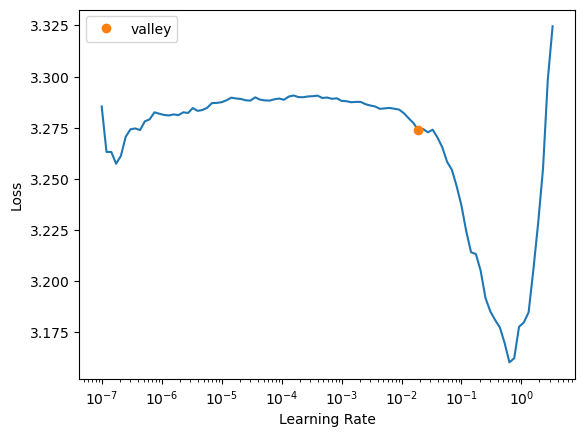

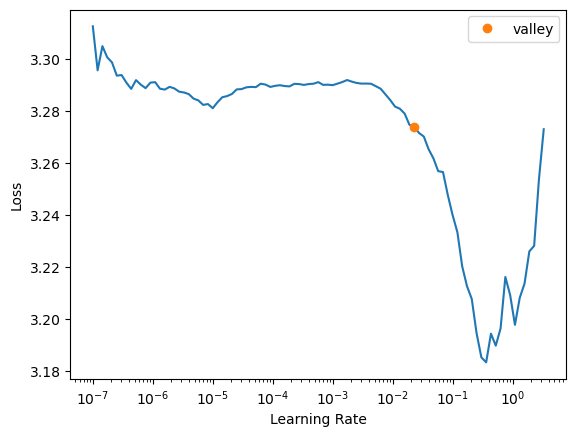

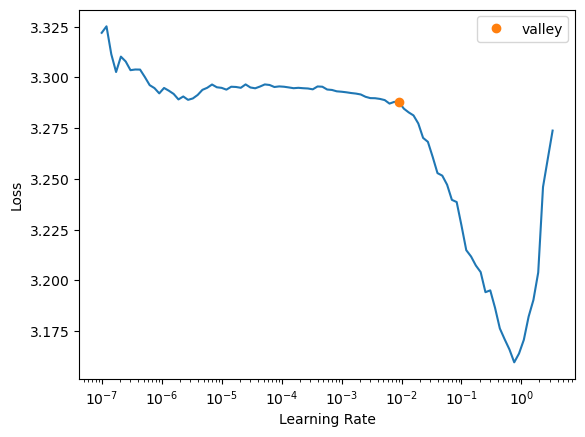

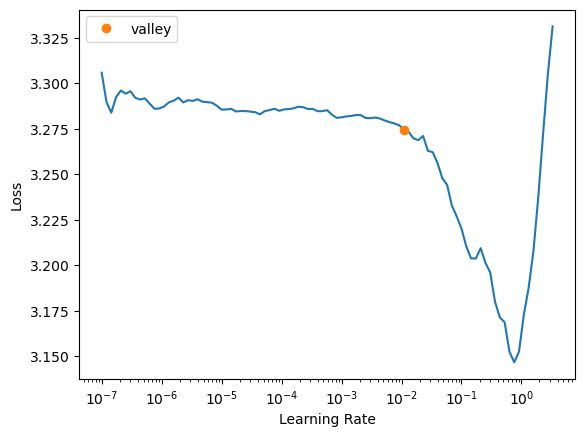

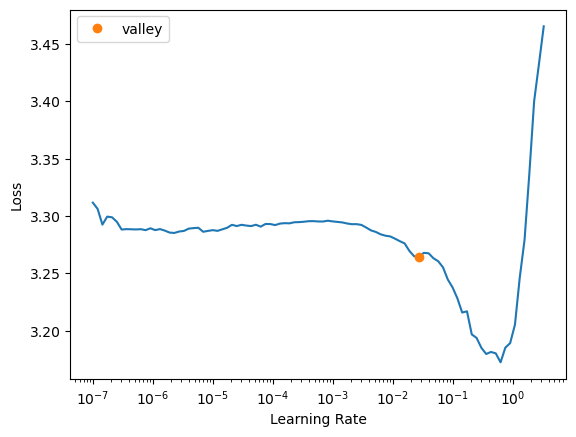

In [9]:
o,dls,categorify = training_dl(log)
m = ControlFlowModel(o)
train_val = train_validate(dls,m,epoch=25,metrics=squeeze_accuracy,loss=squeeze_cross_entropy)

In [17]:
test_log = import_log(f'data/csv/PDC2020_ground_truth/{log_name}.csv.gz')
test_log[test_log['normal'] == False].head(5)

,activity,trace_id,case:pdc:costs,normal,event_id
trace_id,,,,,
trace 4,###start###,trace 4,5.0,False,0
trace 4,t26,trace 4,5.0,False,1
trace 4,t32,trace 4,5.0,False,2
trace 4,t41,trace 4,5.0,False,3
trace 4,t44,trace 4,5.0,False,4


In [23]:
def process_test(test_log,categorify,cat_names='activity'):
    o=PPObj(test_log,procs=categorify,cat_names=cat_names,y_names=cat_names,do_setup=False)
    o.process() # map to the same categories as in the training set
    return o


def predict_next_step(o,m,ws=5):
    wds,idx=partial(windows_fast,ws=ws)(o.xs, o.event_ids)
    res=(m(LongTensor(wds).cuda()))
    return res,idx


def calc_anomaly_score(res,o,idx):
    sm = nn.Softmax(dim=1)
    y = o.items['activity'].iloc[idx].values
    p = sm(res)
    pred = p.max(1)[0]
    truth = p[list(range(0, len(y))),y]
    a_score = ((pred - truth) / pred).cpu().detach().numpy()
    return a_score


def get_anomalies(a_score,o,idx,threshhold=0.98):
    df=pd.DataFrame(columns=['a_score'])
    df['a_score'] = a_score
    df['trace_id'] = o.items.iloc[idx]['trace_id'].values
    df['normal'] = o.items.iloc[idx]['normal'].values
    # print(df.head(50)) # THIS DF CONTAINS ALL THE ANOMALY SCORES

    y_true = (df.loc[df.trace_id.drop_duplicates().index].normal==False).tolist()
    cases = df.loc[df.trace_id.drop_duplicates().index].trace_id.tolist()
    anomalies = set(list(df.loc[df['a_score'] > threshhold]['trace_id']))
    y_pred=[case in anomalies for case in cases]
    return y_pred, y_true

In [24]:
o = process_test(test_log,categorify)
nsp, idx = predict_next_step(o, m)
anomaly_score = calc_anomaly_score(nsp, o, idx)
y_pred, y_true = get_anomalies(anomaly_score,o,idx)

In [25]:
print(f'F1 score: {f1_score(y_true, y_pred)}')
print(f'Accuracy score: {accuracy_score(y_true, y_pred)}')
print(f'Precision score: {precision_score(y_true, y_pred)}')
print(f'Recall score: {recall_score(y_true, y_pred)}')

F1 score: 0.848893166506256
Accuracy score: 0.843
Precision score: 0.747457627118644
Recall score: 0.9821826280623608
